In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as pil
from tensorflow.keras.applications import InceptionV3, inception_v3
from tensorflow.keras.models import Model
import IPython.display as display

In [150]:
PATH = '/kaggle/input/images-dir/mona.jpg'
STEPS = 200
LEARNING_RATE = 0.01
NUMBER_OF_RUNS = 100

## Importing the Image

In [151]:
image = pil.open(PATH)

## Preprocessing

### Resizing and Converting to a Numpy Array

In [152]:
resized_image = image.resize((299, 299))

In [153]:
image_array = np.array(resized_image)
image_array.shape

(299, 299, 3)

## InceptionV3

In [154]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

## Dream Model

### Layers

In [155]:
# mixed0 to mixed10 are concatenated layers 
layer_names = ['mixed10']
# contains the output tensors(activations) of the layers specified by the layer_names
layers = [base_model.get_layer(name).output for name in layer_names]

### Model

In [156]:
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Costum Model

In [157]:
class DeepDream(Model) :
    def __init__(self, model, *args, **kwargs) :
        super().__init__(*args, **kwargs)
        self.model = model
    
    def calculate_layers_loss(self, model, image) :
        # The model expects a batch of images, so the image is converted into a batch of size 1.
        activations = model(tf.expand_dims(image, axis=0))

        if len(activations) == 1:
            activations = [activations]

        # To prevent layers with a larger number of neurons from dominating the loss,
        # using the mean helps alleviate that issue.
        losses = [tf.math.reduce_mean(activation) for activation in activations]

        return tf.reduce_sum(losses)
    
    @tf.function
    def update_image(self, image, steps, learning_rate) :
        loss = tf.constant(0.0)
        for _ in tf.range(steps) :
            with tf.GradientTape() as tape :
                # we are interested in gradients with respect to the image
                tape.watch(image)
                loss = self.calculate_layers_loss(self.model, image)
            
            gradients = tape.gradient(loss, image)
            
            # Normalize the gradients.
            gradients = gradients / (tf.math.reduce_std(gradients) + 1e-8)

            image = image + gradients * learning_rate
            # clipping the image values to a specified min and max.
            image = tf.clip_by_value(image, -1, 1)
            
        return image, loss

In [158]:
model = DeepDream(dream_model)

## Training Loop

In [159]:
# each pixel is in [-1, 1]. Therefore, for showing the image we need to 
def deprocess(image):
    image = 255 * (image + 1.0) / 2.0
    return tf.cast(image, tf.uint8)

def train_loop(model, image, run_count, steps, learning_rate) :
    image = inception_v3.preprocess_input(image)
    image = tf.convert_to_tensor(image)
    
    for _ in range(run_count) :
        image, loss = model.update_image(image,  tf.constant(steps),tf.constant(learning_rate))
        
        display.clear_output(wait=True)
        display.display(pil.fromarray(np.array(deprocess(image))))
        print (f'loss = {loss}')

    result = deprocess(image)
    display.clear_output(wait=True)
    display.display(pil.fromarray(np.array(result)))

    return result

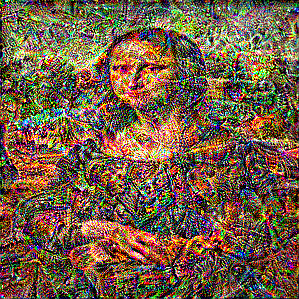

In [160]:
result = train_loop(model, image_array, NUMBER_OF_RUNS, STEPS, LEARNING_RATE)

In [161]:
result_image = pil.fromarray(result.numpy())
result_image = result_image.resize((1080, 1080))
result_image.save('result.png')
result_image.size

(1080, 1080)